### Import necessary packages

In [1]:
import pandas as pd
import pandas_datareader as web
import datetime
import statsmodels.api as sm

### Functions to import price data

In [2]:
def read_price_data(stock_symbol, start_date, end_date, interval):
    """Import price data from Yahoo Finance"""
    try:
        stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    except:
        return None

    prices = stock_data.loc[:, "Adj Close"] # adjusted for stock splits and dividends
    prices = prices.fillna(method="ffill")

    return prices

In [3]:
def get_date_list(stock_symbol, start_date, end_date, interval):
    """Generate list of trading dates"""
    stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    dates = stock_data.index
    
    return dates

### Generate input table for month on month comparison of a stock against S&P 500

In [4]:
index_symbol = "^GSPC" # Index symbol (by default "^GSPC" for the S&P500 index)
stock_symbol = "AAPL" # <-- Please enter Stock symbol

# Generate list of trading days
start_date = datetime.datetime(2017, 10, 1)
end_date = datetime.datetime(2022, 9, 1)
interval = 'm' 
date_list = get_date_list(index_symbol, start_date, end_date, interval=interval)

# Generate empty dataframe
column_header_index = "Index price ({})".format(index_symbol)
column_header_stock = "Stock price ({})".format(stock_symbol)
df = pd.DataFrame(
        columns=[column_header_index, column_header_stock], index=date_list
    )

# Sort dataframe based on date
df = df.sort_index(ascending=False)  

# Import price series into dataframe
try:
    price_series = read_price_data(index_symbol, start_date, end_date, interval=interval)
    df[column_header_index] = price_series
    
    price_series = read_price_data(stock_symbol, start_date, end_date, interval=interval)
    df[column_header_stock] = price_series  
except:
    print('Import failed')

# Print head of dataframe
df.head()

,Index price (^GSPC),Stock price (AAPL)
Date,,
2022-09-01,3901.350098,152.369995
2022-08-01,3955.000000,157.001923
2022-07-01,4130.290039,162.284576
2022-06-01,3785.379883,136.530350
2022-05-01,4132.149902,148.415466


### Calculate monthly returns

In [5]:
#resample based on month, replace null values with value from the previous row, compute percentage change
mtl_ret = df.resample('M').ffill().pct_change() 
mtl_ret = mtl_ret.dropna(axis=0) # get rid of NaN rows
mtl_ret = mtl_ret.sort_index(ascending=False)
mtl_ret.rename(columns = {'Index price (^GSPC)': index_symbol, 'Stock price ('+stock_symbol+')': stock_symbol}, inplace = True)
mtl_ret.head()

,^GSPC,AAPL
Date,,
2022-09-30,-0.013565,-0.029502
2022-08-31,-0.042440,-0.032552
2022-07-31,0.091116,0.188634
2022-06-30,-0.083920,-0.080080
2022-05-31,0.000053,-0.055883


### Define dependant and independant variable

In [6]:
X = mtl_ret[index_symbol] # independant variable
y = mtl_ret[stock_symbol] # dependant variable

X_sm = sm.add_constant(X) # OLS requires the input to have a column of ones
X_sm.head()

,const,^GSPC
Date,,
2022-09-30,1.0,-0.013565
2022-08-31,1.0,-0.042440
2022-07-31,1.0,0.091116
2022-06-30,1.0,-0.083920
2022-05-31,1.0,0.000053


In [7]:
model = sm.OLS(y, X_sm)

In [8]:
results = model.fit()

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     55.85
Date:                Fri, 16 Sep 2022   Prob (F-statistic):           5.18e-10
Time:                        18:19:56   Log-Likelihood:                 79.269
No. Observations:                  59   AIC:                            -154.5
Df Residuals:                      57   BIC:                            -150.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.008      1.938      0.058      -0.001       0.033
^GSPC          1.2377      0.166      7.473      0.000       0.906       1.569
==============================================================================
Omnibus:                        5.922   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                6.148
Skew:                          -0.407   Prob(JB):                       0.0462
Kurtosis:                       4.356   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Visualization of scatter plot

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

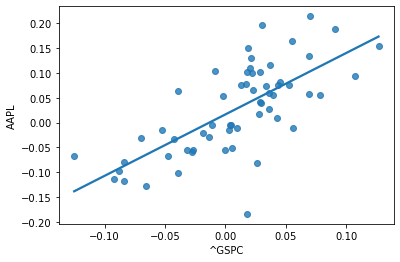

In [11]:
sns.regplot(x=index_symbol, y=stock_symbol, data=mtl_ret, ci = None)
plt.show()